In [1]:
# Pettitt 断点检测法
def Pettitt_change_point_detection(inputdata, p_shr=0.05):
    index = inputdata.index
    inputdata = np.array(inputdata.values)
    n         = inputdata.shape[0]
    k = range(n)
    inputdataT = pd.Series(inputdata)
    r = inputdataT.rank()
    Uk = [2*np.sum(r[0:x])-x*(n + 1) for x in k]
    Uka = list(np.abs(Uk))
    U = np.max(Uka)
    K = index[Uka.index(U)]
    pvalue         = 2 * np.exp((-6 * (U**2))/(n**3 + n**2))
    if pvalue <= p_shr:
        change_point_desc = '显著'
    else:
        change_point_desc = '不显著'
    Pettitt_result = {'突变点位置':K,'突变程度':change_point_desc}
    return K, Pettitt_result


# 循环检测所有显著的断点
def Pettitt_change_points(inputdata, p_shr=0.001):
    change_points = []
    detect_series = [inputdata]
    while len(detect_series) > 0:
        tmp_detect = []
        for series in detect_series:
            K, Pettitt_result = Pettitt_change_point_detection(series, p_shr=p_shr)
            if Pettitt_result['突变程度'] == '显著':
                change_points.append(K)
                tmp_detect.extend([series.loc[:K-1], series.loc[K+1:]])
            else:
                continue
        detect_series = tmp_detect
        continue
    return change_points


def plot_pittitt_change_points(series, ax=None, p_shr=0.001, change_points=None, colors=None):
    from scipy import optimize
    def linear(x, k, b):
        return k * x + b
    
    slopes = []
    if change_points is None:
        change_points = sorted(Pettitt_change_points(series, p_shr))
    change_points_index = [series.index.tolist().index(i) for i in change_points]
    x_arr = np.split(series.index, change_points_index)
    y_arr = np.split(series.values, change_points_index)
    if ax is None:
        fig, ax = plt.subplots()
    i = 0
    for xi, yi in zip(x_arr, y_arr):
        i += 1
        k, b = optimize.curve_fit(linear, xi, yi)[0]  # 最小二乘拟合直线
        y_simu = linear(xi, k, b)  # 拟合直线的预测Y
        slopes.append(k)
        
        # 绘图
        if colors: 
            ax.scatter(xi, yi, label='P{}: {}-{}'.format(i, xi[0], xi[-1]), color=colors[i-1])  # 源数据散点图
            ax.plot(xi, y_simu, '--', color=colors[i-1])  # 拟合直线图
        else: 
            ax.scatter(xi, yi, label='P{}: {}-{}'.format(i, xi[0], xi[-1])) 
            ax.plot(xi, y_simu, '--')
    
    ax.legend()
    y_position = ax.get_ylim()[1]
    for cp in change_points:
        ax.axvline(x=cp, ls=":", c="gray", lw=2)
        # ax.text(cp, y_position, "{}".format(cp), va='top', ha='center')  注释年份
    return slopes

[-0.0008170718281695466]

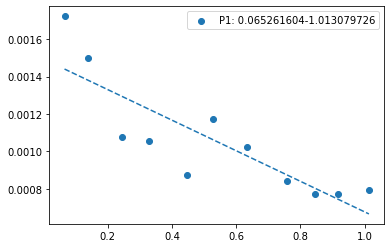

In [2]:
from scipy import optimize
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

x = np.array([0.065261604, 0.138147939, 0.244305463, 0.32836787, 0.446749604, 0.528048691, 0.633471934, 0.75693624, 0.845070202, 0.918184341, 1.013079726
], dtype=float)
y = np.array([0.001722916, 0.00149782, 0.001077492, 0.001055566, 0.000871638, 0.001171418, 0.001023294, 0.000841527, 0.000771357, 0.000773875, 0.000791953])

plot_pittitt_change_points(pd.Series(y, index=x))

# def piecewise_linear(x, x0, y0, k1, k2):
#     return np.piecewise(x, [x < x0, x >= x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])

# p , e = optimize.curve_fit(piecewise_linear, x, y)
# xd = np.linspace(0, 1.1, 100)
# plt.plot(x, y, "o")
# plt.plot(xd, piecewise_linear(xd, *p))

5.0
y = poly([ 0.00179087 -0.00223162])    , if x in [0.065261604, 0.446749604]
y = poly([ 0.00154811 -0.00083396])    , if x in [0.528048691, 1.013079726]


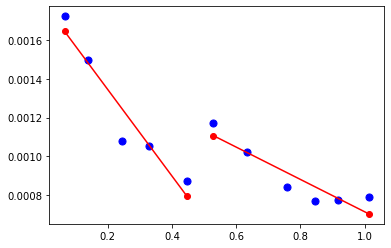

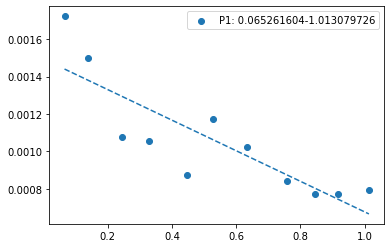

In [34]:
import numpy as np
import numpy.polynomial.polynomial as npoly
from scipy import optimize
import matplotlib.pyplot as plt
np.random.seed(2017)

def f(breakpoints, x, y, fcache):
    if num_breakpoints == 1:
        breakpoints = int(breakpoints)
        xs = np.split(x, [breakpoints])
    else:
        breakpoints = tuple(map(int, sorted(breakpoints)))
        xs = np.split(x, breakpoints)
    if breakpoints not in fcache:
        total_error = 0
        for f, xi, yi in find_best_piecewise_polynomial(breakpoints, x, y):
            total_error += ((f(xi) - yi)**2).sum()
        fcache[breakpoints] = total_error
    # print('{} --> {}'.format(breakpoints, fcache[breakpoints]))
    return fcache[breakpoints]

def find_best_piecewise_polynomial(breakpoints, x, y):
    if num_breakpoints == 1:
        breakpoints = int(breakpoints)
        xs = np.split(x, [breakpoints])
        ys = np.split(y, [breakpoints])
    else:
        breakpoints = tuple(map(int, sorted(breakpoints)))
        xs = np.split(x, breakpoints)
        ys = np.split(y, breakpoints)
    result = []
    for xi, yi in zip(xs, ys):
        if len(xi) < 2: continue
        coefs = npoly.polyfit(xi, yi, 1)
        f = npoly.Polynomial(coefs)
        result.append([f, xi, yi])
    return result

x = np.array([0.065261604, 0.138147939, 0.244305463, 0.32836787, 0.446749604, 0.528048691, 0.633471934, 0.75693624, 0.845070202, 0.918184341, 1.013079726
], dtype=float)
y = np.array([0.001722916, 0.00149782, 0.001077492, 0.001055566, 0.000871638, 0.001171418, 0.001023294, 0.000841527, 0.000771357, 0.000773875, 0.000791953])
# Add some noise to make it exciting :)

num_breakpoints = 1  # 设置断点数量
breakpoints = optimize.brute(
    f, [slice(1, len(x), 1)]*num_breakpoints, args=(x, y, {}), finish=None)  # 

print(breakpoints)

plt.scatter(x, y, c='blue', s=50)
for f, xi, yi in find_best_piecewise_polynomial(breakpoints, x, y):
    x_interval = np.array([xi.min(), xi.max()])
    print('y = {:35s}, if x in [{}, {}]'.format(str(f), *x_interval))
    plt.plot(x_interval, f(x_interval), 'ro-')


plot_pittitt_change_points(pd.Series(y, index=x), p_shr=0.05)
plt.show()

In [ ]:
import numpy as np
import numpy.polynomial.polynomial as npoly
from scipy import optimize
import matplotlib.pyplot as plt

# 定义需要暴力搜索的分段函数


In [32]:
x
np.split(x, [2])

[array([0.0652616 , 0.13814794]),
 array([0.24430546, 0.32836787, 0.4467496 , 0.52804869, 0.63347193,
        0.75693624, 0.8450702 , 0.91818434, 1.01307973])]